## A OOTB Example

In [8]:
import tensorflow as tf
import tensorflow_datasets.public_api as tfds

import sys
sys.path += ['../src/']

from datasets.StackOverflowDataset import StackOverflowDataset

MAX_FEATURES = 20000
MAX_LEN = 7

ds = tfds.load('StackOverflowDataset', split='train', as_supervised=True)\
      .shuffle(buffer_size=1000)\
      .batch(256)\
      .map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), 20)))\

train_ds, test_ds = ds.take(int(len(ds) * 0.83)), ds.skip(int(len(ds) * 0.83))

vectorize_layer = tf.keras.layers.TextVectorization(output_sequence_length=MAX_LEN, max_tokens=MAX_FEATURES, pad_to_max_tokens=True)
vectorize_layer.adapt(ds.map(lambda x, _: x))

model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(1,), dtype=tf.string),
  vectorize_layer,
  tf.keras.layers.Embedding(MAX_FEATURES, 128),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
  tf.keras.layers.Dense(20, activation='softmax')
])

model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=tf.keras.metrics.CategoricalAccuracy()
)

model.fit(train_ds, epochs=2)
model.evaluate(test_ds)

Epoch 1/2
65/65 [==============================] - 6s 32ms/step - loss: 2.5841 - categorical_accuracy: 0.4251
Epoch 2/2
14/14 [==============================] - 1s 10ms/step - loss: 0.9923 - categorical_accuracy: 0.7366


[0.9922823309898376, 0.7366071343421936]

## Below is observe dataset shape

In [9]:
import sys
import os
import string
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.path += ['../src/']
from utils.utils import tqdm_joblib

In [10]:
URL=[
    'https://raw.githubusercontent.com/jacoxu/StackOverflow/master/rawText/title_StackOverflow.txt', 
    'https://raw.githubusercontent.com/jacoxu/StackOverflow/master/rawText/label_StackOverflow.txt'
]
MAX_LEN=-1
FILTER='"&(),-/:;<=>[\\]_`{|}~\t\n0123456789' or string.punctuation
LABEL= {
    1: 'wordpress',
    2: 'oracle',
    3: 'svn',
    4: 'apache',
    5: 'excel',
    6: 'matlab',
    7: 'visual-studio',
    8: 'cocoa',
    9: 'osx',
    10: 'bash',
    11: 'spring',
    12: 'hibernate',
    13: 'scala',
    14: 'sharepoint',
    15: 'ajax',
    16: 'qt',
    17: 'drupal',
    18: 'linq',
    19: 'haskell',
    20: 'magento',
}


title_path = tf.keras.utils.get_file('stack_overflow-title', URL[0])
label_path = tf.keras.utils.get_file('stack_overflow-label', URL[1])
df = pd.DataFrame(columns=['text', 'label'])
df['text'] = pd.read_fwf(title_path, header=None, on_bad_lines='skip')[0]
df['label'] = pd.read_fwf(label_path, header=None, on_bad_lines='skip')[0]

In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=FILTER, lower=True, split=' ')
tokenizer.fit_on_texts(np.array(df['text']))
vocab_size = len(tokenizer.word_index) + 1

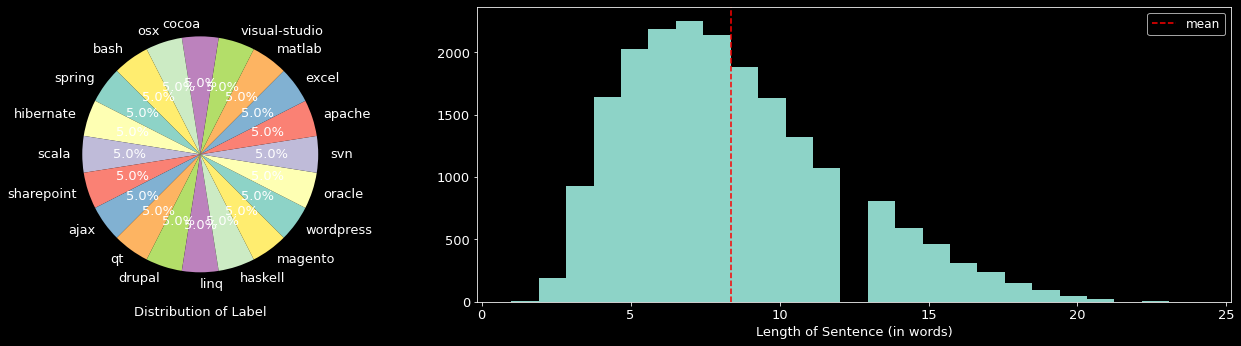

In [12]:
plt.rcParams['font.size'] = 13
plt.rcParams['figure.autolayout'] = True

label = list(LABEL.values())
count = list(df['label'].value_counts().sort_index().values)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.tight_layout()

ax1.pie(count, labels=label, startangle=-45, autopct='%.1f%%')
ax1.set_xlabel('Distribution of Label')
ax1.title.set_y(-0.01)

lengths=[]
for x in range(len(df)):
    i = df['text'][x]
    i = tokenizer.texts_to_sequences([i])
    lengths.append(len(i[0]))
lengths = np.array(lengths)
fig = ax2.hist(lengths, bins=25)
ax2.set_xlabel('Length of Sentence (in words)')
ax2.axvline(x=lengths.mean(), color='red',ls='--', label='mean')
ax2.legend(loc='upper right', prop={'size': 12})

plt.show()

In [13]:
df['label'] = (df['label'] == True) * 1
texts = np.array(df['text'])
texts = tokenizer.texts_to_sequences(texts)

if MAX_LEN > 0:
    texts = tf.keras.preprocessing.sequence.pad_sequences(texts, maxlen=MAX_LEN, dtype='float', padding='post', truncating='post', value=0.0)

texts = np.array(texts)
labels = np.array([float(j) for j in df['label']])

/tmp/ipykernel_3477/2272974764.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  texts = np.array(texts)


In [14]:
x_train, x_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=0)